# Seedlings Project
- The aim is to train a model that can differentiate between 12 different types of seedlings
- This will be done via transfer learning using the Imagenet model - Inception V3
- Will use tf.data and Pandas to handle input pipelines for training and testing and exploratory analyses

## Testing for GPU 


To Test if you have GPU set up. Run the Cell below. If no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download the data

In [2]:
!wget -qq https://www.dropbox.com/s/nwzfqtrplgbyi5m/v2-plant-seedlings-dataset.zip?dl=0 
!unzip -qq v2-plant-seedlings-dataset.zip?dl=0 
!rm v2-plant-seedlings-dataset.zip?dl=0 
!ls

 Black-grass	    'Fat Hen'		 'Shepherd’s Purse'
 Charlock	    'Loose Silky-bent'	 'Small-flowered Cranesbill'
 Cleavers	     Maize		 'Sugar beet'
'Common Chickweed'   sample_data
'Common wheat'	    'Scentless Mayweed'


In [3]:
# Look at files listed under 'Sugar beet'- shows the .png images
!ls 'Sugar beet'

100.png  148.png  195.png  241.png  289.png  336.png  383.png  42.png	58.png
101.png  149.png  196.png  242.png  290.png  337.png  384.png  430.png	59.png
102.png  14.png   197.png  243.png  291.png  338.png  385.png  431.png	5.png
103.png  150.png  198.png  244.png  292.png  339.png  386.png  432.png	60.png
104.png  151.png  199.png  245.png  293.png  33.png   387.png  433.png	61.png
105.png  152.png  19.png   246.png  294.png  340.png  388.png  434.png	62.png
106.png  153.png  1.png    247.png  295.png  341.png  389.png  435.png	63.png
107.png  154.png  200.png  248.png  296.png  342.png  38.png   436.png	64.png
108.png  155.png  201.png  249.png  297.png  343.png  390.png  437.png	65.png
109.png  156.png  202.png  24.png   298.png  344.png  391.png  438.png	66.png
10.png	 157.png  203.png  250.png  299.png  345.png  392.png  439.png	67.png
110.png  158.png  204.png  251.png  29.png   346.png  393.png  43.png	68.png
111.png  159.png  205.png  252.png  2.png    347.png  394.png  440.p

In [4]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import keras

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

Using TensorFlow backend.


In [5]:
# Check versions of tf and keras used
print(tf.__version__)
print(tf.keras.__version__)
print(keras.__version__)

1.13.1
2.2.4-tf
2.2.4


In [0]:
# Set up some Hyperparameters: batch size, epochs and learning rate

batch_size = 32
epochs = 10
lr = 0.001

## File conversion
- convert raw files in folders so that it can be fed into tf.data
- use glob to get lists of all files in the directories
- then, convert the lists into dataframes
- add class numbers
- split to training set (90%) and test set (10%)
- randomly shuffle lists

In [7]:
# imports and getting files using glob
import glob
import pandas as pd

filenames_n0 = glob.glob('./Black-grass/*.png')
filenames_n1 = glob.glob('./Charlock/*.png')
filenames_n2 = glob.glob('./Cleavers/*.png')
filenames_n3 = glob.glob('./Common Chickweed/*.png')
filenames_n4 = glob.glob('./Common wheat/*.png')
filenames_n5 = glob.glob('./Fat Hen/*.png')
filenames_n6 = glob.glob('./Loose Silky-bent/*.png')
filenames_n7 = glob.glob('./Maize/*.png')
filenames_n8 = glob.glob('./Scentless Mayweed/*.png')
filenames_n9 = glob.glob('./Shepherd’s Purse/*.png')
filenames_n10 = glob.glob('./Small-flowered Cranesbill/*.png')
filenames_n11 = glob.glob('./Sugar beet/*.png')

names = ['Black-grass', 'Charlock','Cleavers','Common Chickweed','Common wheat',
        'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 
        'Small-flowered Cranesbill', 'Sugar beet']
len(filenames_n0)

309

In [8]:
# Check a folder to see files listed in it
filenames_n1[:10]

['./Charlock/420.png',
 './Charlock/332.png',
 './Charlock/383.png',
 './Charlock/50.png',
 './Charlock/62.png',
 './Charlock/158.png',
 './Charlock/208.png',
 './Charlock/6.png',
 './Charlock/73.png',
 './Charlock/429.png']

In [9]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df1 = pd.DataFrame(filenames_n1, columns = ["filename"])
df2 = pd.DataFrame(filenames_n2, columns = ["filename"])
df3 = pd.DataFrame(filenames_n3, columns = ["filename"])
df4 = pd.DataFrame(filenames_n4, columns = ["filename"])
df5 = pd.DataFrame(filenames_n5, columns = ["filename"])
df6 = pd.DataFrame(filenames_n6, columns = ["filename"])
df7 = pd.DataFrame(filenames_n7, columns = ["filename"])
df8 = pd.DataFrame(filenames_n8, columns = ["filename"])
df9 = pd.DataFrame(filenames_n9, columns = ["filename"])
df10 = pd.DataFrame(filenames_n10, columns = ["filename"])
df11 = pd.DataFrame(filenames_n11, columns = ["filename"])

# Check one df to see first 5 listings
df.head()

,filename
0,./Black-grass/332.png
1,./Black-grass/50.png
2,./Black-grass/62.png
3,./Black-grass/208.png
4,./Black-grass/6.png


In [10]:
# Add Class columns - each df will have a specific class number assignmed to it
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df1['class'] = pd.Series([1 for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series([2 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([3 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([4 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([5 for x in range(len(df5.index))], index=df5.index)
df6['class'] = pd.Series([6 for x in range(len(df6.index))], index=df6.index)
df7['class'] = pd.Series([7 for x in range(len(df7.index))], index=df7.index)
df8['class'] = pd.Series([8 for x in range(len(df8.index))], index=df8.index)
df9['class'] = pd.Series([9 for x in range(len(df9.index))], index=df9.index)
df10['class'] = pd.Series([10 for x in range(len(df10.index))], index=df10.index)
df11['class'] = pd.Series([11 for x in range(len(df11.index))], index=df11.index)

# Check one df to see first 5 listings
df1.head()

,filename,class
0,./Charlock/420.png,1
1,./Charlock/332.png,1
2,./Charlock/383.png,1
3,./Charlock/50.png,1
4,./Charlock/62.png,1


In [0]:
# Split each df into train and validation sets. 90% training
# Combine all training df into one: df_new_train
# Combine all validation df into one: df_new_val
# Shuffle the combined training and validation datasets

train_set_percentage = .9

train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df1 = df1[:int(len(df1)*train_set_percentage)]
val_df1 = df1[int(len(df1)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]

train_df6 = df6[:int(len(df6)*train_set_percentage)]
val_df6 = df6[int(len(df6)*train_set_percentage):]

train_df7 = df7[:int(len(df7)*train_set_percentage)]
val_df7 = df7[int(len(df7)*train_set_percentage):]

train_df8 = df8[:int(len(df8)*train_set_percentage)]
val_df8 = df8[int(len(df8)*train_set_percentage):]

train_df9 = df9[:int(len(df9)*train_set_percentage)]
val_df9 = df9[int(len(df9)*train_set_percentage):]

train_df10 = df10[:int(len(df10)*train_set_percentage)]
val_df10 = df10[int(len(df10)*train_set_percentage):]

train_df11 = df11[:int(len(df11)*train_set_percentage)]
val_df11 = df11[int(len(df11)*train_set_percentage):]


df_new_train = pd.concat([train_df, train_df1, train_df2, train_df3, train_df4, 
                          train_df5, train_df6, train_df7, train_df8, train_df9,
                          train_df10, train_df11])
df_new_val = pd.concat([val_df, val_df1, val_df2, val_df3, val_df4, val_df5,
                       val_df6, val_df7, val_df8, val_df9, val_df10,
                       val_df11])

df_new_train.shape

# Shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

##  Examine the Training dataset

In [12]:
# Look at first 5 records of training dataset
df.head()

,filename,class
0,./Loose Silky-bent/303.png,6
1,./Charlock/55.png,1
2,./Small-flowered Cranesbill/252.png,10
3,./Scentless Mayweed/256.png,8
4,./Fat Hen/206.png,5


In [13]:
# Look at data shape of training and validation datasets
print("Training dataset shape:", df.shape)
print("Validation dataset shape:", df_val.shape)

# Get an array of the unique classes in each dataset
print("Unique classes:", df['class'].unique())

Training dataset shape: (4979, 2)
Validation dataset shape: (560, 2)
Unique classes: [ 6  1 10  8  5  0  3  7 11  4  2  9]


6     685
3     641
8     546
10    518
5     484
11    416
1     406
2     301
0     278
9     246
7     231
4     227
Name: class, dtype: int64


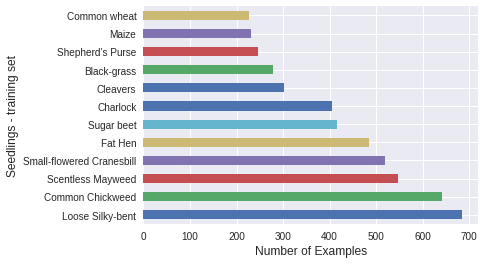

In [14]:
# No of items in each unique class
print(df['class'].value_counts())

labels = ['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed', 'Small-flowered Cranesbill', 
         'Fat Hen', 'Sugar beet', 'Charlock', 'Cleavers', 'Black-grass', 'Shepherd’s Purse', 'Maize', 'Common wheat'  ]

# Plot graph of items in each unique class
ax = df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Seedlings - training set", fontsize=12)
ax.set_yticklabels(labels)
plt.show()

## Make the pipeline for loading and resizing the images

In [15]:
# Convert training dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert validation dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 5

df.shape

(4979, 2)

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it to a fixed shape
# For Imagenet, use 299 by 299
img_rows, img_cols = 299,299

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_png(image_string, channels=3)
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# A vector of training filenames - from a list
filenames = tf.constant(train_filenames_list)

# A vector if training labels to match - from a list
labels = tf.constant(train_labels_list)

# Create the same as above for validation filenames and labels
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

## Assembling the Data pipeline using tf.data

In [0]:
# For training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

In [0]:
# For validation dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)

## Create the network
Base model



In [20]:
# InceptionV3 Model - trained on image net
# Base model
base_model = InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


In [0]:
#model.summary()

## Create a simple head for the model that we can train

In [0]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Classes for characters
predictions = Dense(num_classes, activation='softmax')(x)

In [0]:
# Creating the model that we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# If you use InceptionV3 you must freeze the weights layers BUT NOT batchnorm layers
# Freeze the InceptionV3 layers except the BatchNorm

for layer in base_model.layers:
    if 'batch' in layer.name:
#       print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 

## Select an Optimizer 

In [0]:
# Create model optimizer using tf optimizer with lr setting the learning rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

## Compile the model

In [0]:
# Compile the model 

model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

## Call backs

In [0]:
# Make a directory for checkpoints
!mkdir checkpoints

checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

Steps = 3888 / batch_size

In [28]:
train_steps = 100
val_steps = 100

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 100
val steps: 100


## Fit the model

We pass in:
- the training set
- the steps for how many times we want to sample a batch to be one epoch
- number of epochs
- validation set
- number of steps for validation

In [29]:
# Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 99/100 [============================>.] - ETA: 1s - loss: 0.3056 - acc: 0.4088
Epoch 00001: val_loss improved from inf to 0.28567, saving model to ./checkpoints/weights_01_0.34.hdf5
100/100 [==============================] - 212s 2s/step - loss: 0.3031 - acc: 0.4097 - val_loss: 0.2857 - val_acc: 0.3403
Epoch 2/10
 99/100 [============================>.] - ETA: 1s - loss: 0.1039 - acc: 0.5006
Epoch 00002: val_loss improved from 0.28567 to 0.07017, saving model to ./checkpoints/weights_02_0.50.hdf5
100/100 [==============================] - 158s 2s/step - loss: 0.1035 - acc: 0.5000 - val_loss: 0.0702 - val_acc: 0.5000
Epoch 3/10
 99/100 [============================>.] - ETA: 1s - loss: 0.0635 - acc: 0.5237
Epoch 00003: val_loss improved from 0.07017 to 0.04840, saving model to ./checkpoints/weights_03_0.57.hdf5
100/100 [==============================] - 157s 2s/step - loss: 0.0638 - acc: 0.5234 - val_loss: 0.0484 - val_acc: 0.5

In [30]:
# Look at checkpoints
!ls checkpoints

weights_01_0.34.hdf5  weights_04_0.53.hdf5  weights_10_0.58.hdf5
weights_02_0.50.hdf5  weights_05_0.56.hdf5
weights_03_0.57.hdf5  weights_06_0.59.hdf5


In [31]:
# Define model metrics
metrics = model.evaluate(valid_dataset,steps=50)

print("model accuracy:",metrics[1])

50/50 [==============================] - 28s 557ms/step - loss: 0.0133 - acc: 0.5750
model accuracy: 0.575


#### Weights for highest validation accuracy used


In [0]:
# Weights for highest accuracy/ lowest loss 
model.load_weights('./checkpoints/weights_10_0.58.hdf5')

### Define predictions

In [69]:
# Make predictions using validation dataset
preds = model.predict(valid_dataset,steps=10)
preds = preds.argmax(axis=-1)

preds.shape

(320,)

In [70]:
test_labels = val_labels_list[0:320]
len(test_labels)

320

### Make a Confusion Matrix

In [0]:
# Import libraries and define confusion matrix

from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [0]:
# Function for plotting confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.03571429 0.96428571 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.02564103 0.97435897 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.125      0.         0.         0.         0.875      0.
  0.         0.         0.         0.         0.         0.        ]
 [0.27272727 0.15151515 0.21212121 0.36363636 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.06666667 0.46666667 0.06666667 0.13333333 0.26666667 0.
  0.     

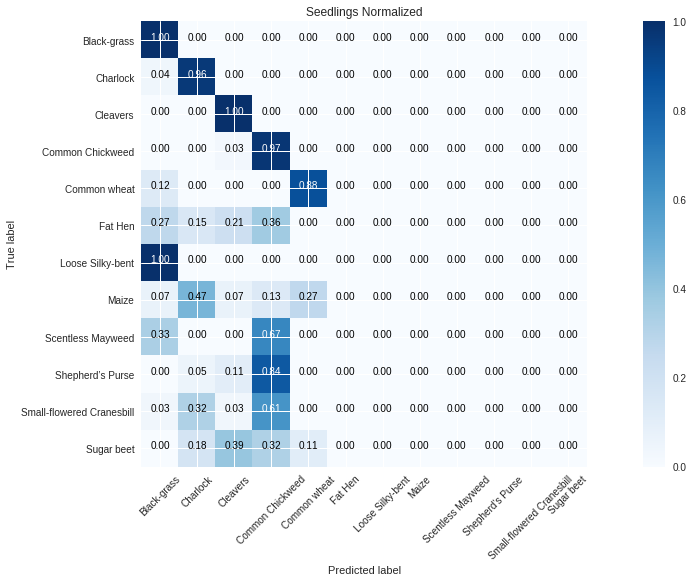

In [73]:
cm_plot_labels = names

# Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Seedlings Normalized')

plt.show()

### Save the Model and weights. Load model

In [0]:
# Save model

model.save('seedlings.h5')

In [0]:
# Save model weights
model.save_weights('seedlings_weights.h5', save_format='h5')

In [76]:
!ls

 Black-grass	     sample_data
 Charlock	    'Scentless Mayweed'
 checkpoint	     seedlings.h5
 checkpoints	     seedlings_tf.data-00000-of-00001
 Cleavers	     seedlings_tf.index
'Common Chickweed'   seedlings_weights.h5
'Common wheat'	    'Shepherd’s Purse'
'Fat Hen'	    'Small-flowered Cranesbill'
'Loose Silky-bent'  'Sugar beet'
 Maize


In [77]:
# Save model weight to directory
model.save_weights('./seedlings_tf')


Consider using a TensorFlow optimizer from `tf.train`.


In [78]:
# Check directory to see saved listings
!ls

 Black-grass	     sample_data
 Charlock	    'Scentless Mayweed'
 checkpoint	     seedlings.h5
 checkpoints	     seedlings_tf.data-00000-of-00001
 Cleavers	     seedlings_tf.index
'Common Chickweed'   seedlings_weights.h5
'Common wheat'	    'Shepherd’s Purse'
'Fat Hen'	    'Small-flowered Cranesbill'
'Loose Silky-bent'  'Sugar beet'
 Maize


In [0]:
# Load saved model
model = load_model('seedlings.h5')

## Make Predictions
We'll make 3 predictions in this notebook

### Prediction 1

In [80]:
# Look at first 5 items of validation dataset

df_val.head()

,filename,class
0,./Shepherd’s Purse/135.png,9
1,./Loose Silky-bent/569.png,6
2,./Fat Hen/234.png,5
3,./Shepherd’s Purse/31.png,9
4,./Charlock/363.png,1


./Common Chickweed/84.png


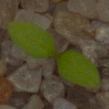

In [81]:
# Look at an image from validation dataset (index 7)

from IPython.display import Image

image_path = df_val['filename'][7]
print(df_val['filename'][7])
Image(image_path)

In [82]:
# Load image into format for model and print shape

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

Input image shape: (1, 299, 299, 3)


In [83]:
# Use model to make a preduction of what type seedling this image is

pred = model.predict(x)
print('Predicted:', pred)

# Prediction number
print('Predicted: ', np.argmax(pred))

# What the seedling is
result= np.argmax(pred)
if result==0:
    print('Its Black-grass')
elif result==1:
    print('Its Charlock')
elif result==2:
    print('Its Cleavers')
elif result==3:
    print('Its Common Chickweed')
elif result==4:
    print('Its Common wheat')
elif result==5:
    print('Its Fat Hen')
elif result==6:
    print('Its Loose Silky-bent')
elif result==7:
    print('Its Maize')
elif result==8:
    print('Its Scentless Mayweed')    
elif result==9:
    print('Its Sheperds Purse')
elif result==10:
    print('Its Small-flowered Cranesbill')
elif result==11:
    print('Its Sugar beet')  

Predicted: [[6.9193046e-10 3.8967846e-10 6.3028089e-08 9.9999988e-01 1.2142234e-12]]
Predicted:  3
Its Common Chickweed


#### The above seedling image is predicted as Common Chickweed. We can see from loading the image that it's a Common Chickweed. This was an accuracte prediction. From the confusion matrix, we can also see that Common Chickweed's are predicted with 100% accuracy.

### Prediction 2

./Fat Hen/234.png


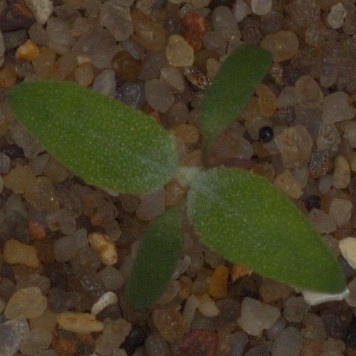

In [84]:
# Look at an image from validation dataset (index 2)

image_path = df_val['filename'][2]
print(df_val['filename'][2])
Image(image_path)

In [85]:
# Load image into format for model and print shape
img_path = os.path.join(image_path)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

# Use model to make a preduction of what type seedling this image is
pred = model.predict(x)
print('Predicted:', pred)

# Prediction number
print('Predicted: ', np.argmax(pred))

# What the seedling is
result= np.argmax(pred)
if result==0:
    print('Its Black-grass')
elif result==1:
    print('Its Charlock')
elif result==2:
    print('Its Cleavers')
elif result==3:
    print('Its Common Chickweed')
elif result==4:
    print('Its Common wheat')
elif result==5:
    print('Its Fat Hen')
elif result==6:
    print('Its Loose Silky-bent')
elif result==7:
    print('Its Maize')
elif result==8:
    print('Its Scentless Mayweed')    
elif result==9:
    print('Its Sheperds Purse')
elif result==10:
    print('Its Small-flowered Cranesbill')
elif result==11:
    print('Its Sugar beet') 

Input image shape: (1, 299, 299, 3)
Predicted: [[1.9540887e-03 1.1994597e-03 2.6113310e-01 7.3568404e-01 2.9326458e-05]]
Predicted:  3
Its Common Chickweed


#### The above seedling image is predicted as Common Chickweed. We can see from loading the image that it's a Fat Hen. This was not an accuracte prediction. From the confusion matrix, we can also see that the Fat Hen has approx 36% chance of being predicted as a Common Chickweed.


### Prediction 3

./Scentless Mayweed/31.png


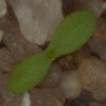

In [86]:
# Look at an image from validation dataset (index 2)

image_path = df_val['filename'][50]
print(df_val['filename'][50])
Image(image_path)

In [87]:
# Load image into format for model and print shape
img_path = os.path.join(image_path)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

# Use model to make a preduction of what type seedling this image is
pred = model.predict(x)
print('Predicted:', pred)

# Prediction number
print('Predicted: ', np.argmax(pred))

# What the seedling is
result= np.argmax(pred)
if result==0:
    print('Its Black-grass')
elif result==1:
    print('Its Charlock')
elif result==2:
    print('Its Cleavers')
elif result==3:
    print('Its Common Chickweed')
elif result==4:
    print('Its Common wheat')
elif result==5:
    print('Its Fat Hen')
elif result==6:
    print('Its Loose Silky-bent')
elif result==7:
    print('Its Maize')
elif result==8:
    print('Its Scentless Mayweed')    
elif result==9:
    print('Its Sheperds Purse')
elif result==10:
    print('Its Small-flowered Cranesbill')
elif result==11:
    print('Its Sugar beet') 

Input image shape: (1, 299, 299, 3)
Predicted: [[1.8967569e-08 8.8803347e-08 2.3702964e-07 9.9999964e-01 1.6995758e-10]]
Predicted:  3
Its Common Chickweed


#### The above seedling image is predicted as Common Chickweed. We can see from loading the image that it's a Scentless Mayweed. This was a fairly inaccurate prediction. From the confusion matrix, we can also see that the Scentless Mayweed has an approx 67% chance of being predicted as a Common Chickweed

### Saving the model and weights back to local machine

In [0]:
# Downloading from colab to local machine

from google.colab import files
files.download('seedlings.h5')  